# Scanning 

In [2]:
from film_util import FilmScan, StripSplit

import numpy as np
import cv2 as cv
import copy

from IPython.display import display
from PIL import Image

The 110 

In [3]:
def imdisp(img, height=1000): 
    ar = img.shape[1] / img.shape[0]
    
    width = ar * height
    img_thumb = cv.resize(img, (int(width), int(height)))
    display(Image.fromarray(img_thumb))

In [4]:
im_path = 'img/110.jpeg'

im = FilmScan.open(im_path)

# convert the image to grayscale so our image operations will work
im_color = copy.deepcopy(im)

im = im.convert('L')

img = np.array(im)
img_color = np.array(im_color)

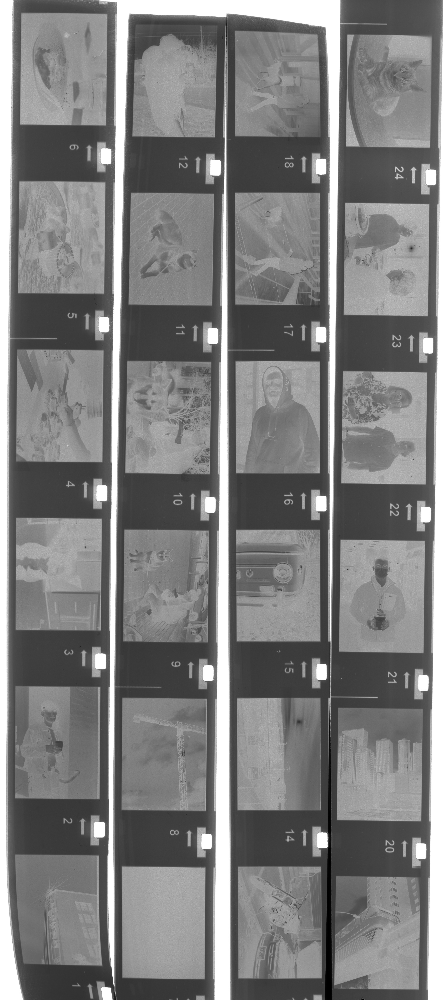

In [9]:
imdisp(img)

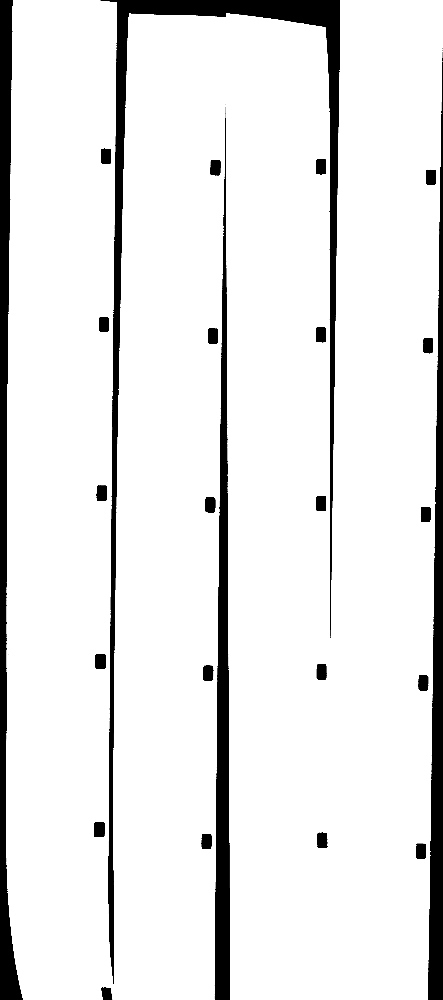

In [10]:
# optionally invert, then threshold
do_invert = True

if do_invert:
    img = (255 - img)

_, img_th = cv.threshold(img, 10, 255, cv.THRESH_BINARY)

imdisp(img_th)

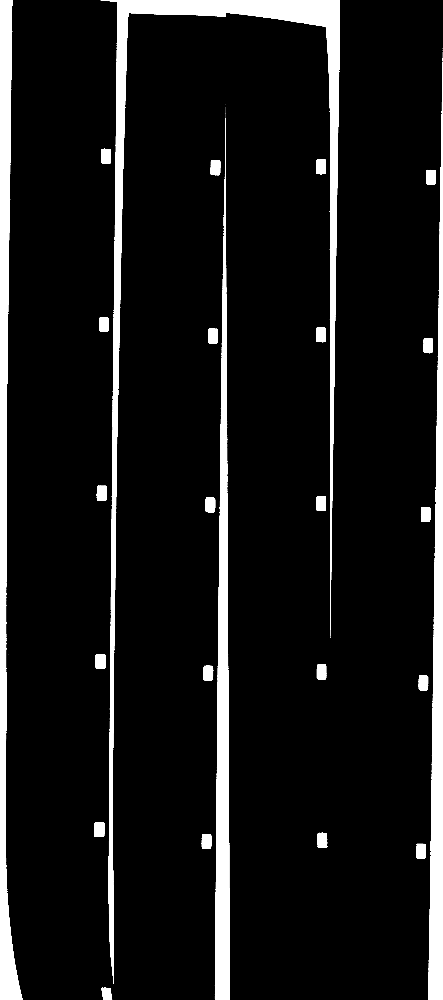

In [11]:
# invert
img_inv = 255 - img_th

imdisp(img_inv)

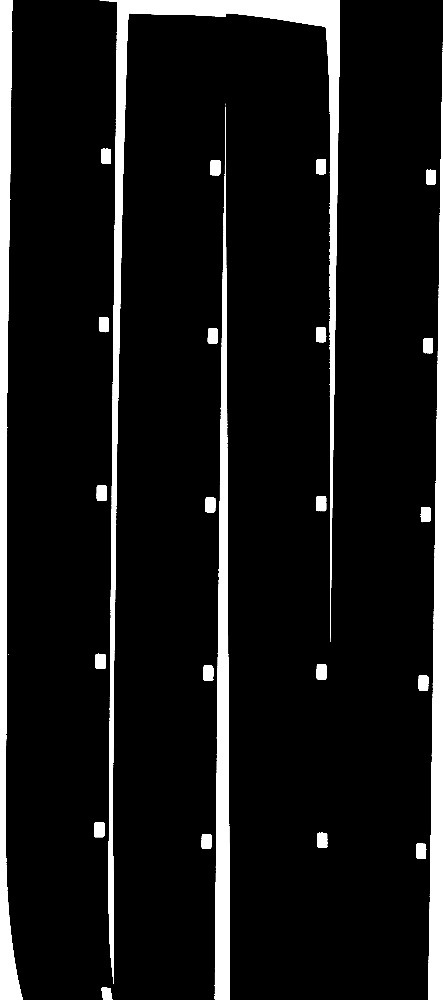

In [12]:
# dilate the image to clean up perfs

kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
img_dil = cv.dilate(img_inv, kernel)

imdisp(img_dil)

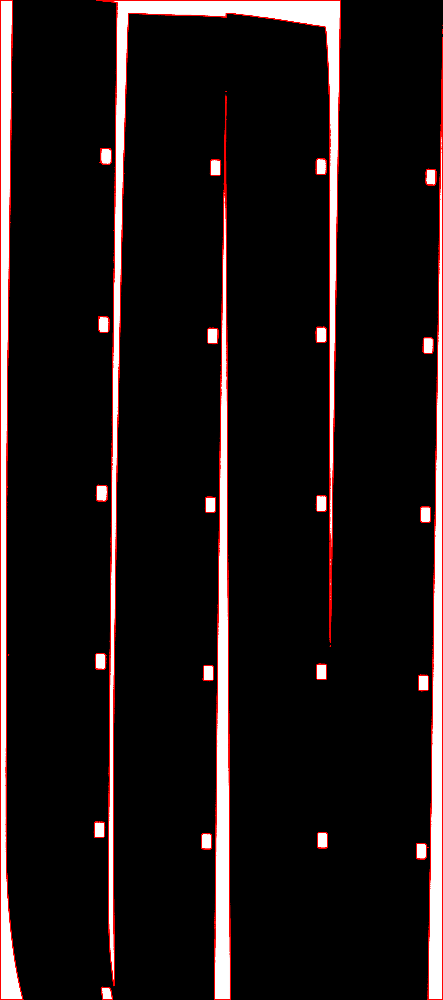

In [13]:
# find contours

conts, _ = cv.findContours(img_dil, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

img_cont = cv.cvtColor(img_dil, cv.COLOR_GRAY2RGB)
cv.drawContours(img_cont, conts, -1, (255,0,0), 8, cv.LINE_AA)

imdisp(img_cont)

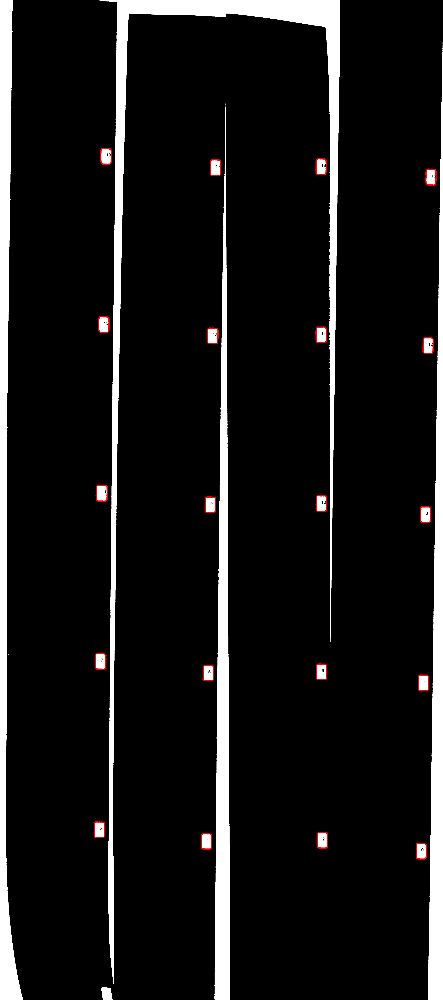

In [14]:
# filter contours based on area to find perfs

def perf_metric(cont):
    # 16mm film
    perf_min_area = 3000
    perf_max_area = 6000
    
    min_ar = 1.1
    max_ar = 1.4
    
    min_p = 250
    max_p = 300
    
    # 110 film
    perf_min_area = 9000
    perf_max_area = 12000
    
    min_ar = 1.4
    max_ar = 1.6
    
    min_p = 390
    max_p = 450
    
    # first, filter by area
    if perf_min_area < cv.contourArea(cont) < perf_max_area:
        # then refine the metric with aspect ratio
        rect = cv.minAreaRect(cont)
        
        ar = rect[1][1] / rect[1][0]
        if ar < 1:
            ar = 1.0/ar
        
        p = cv.arcLength(cont, True)
        
        if min_ar < ar < max_ar and min_p < p < max_p:
            return True
    
    return False

# calculate perf centroids
perf_conts = []
perf_centroids = []
for cont in conts:
    if perf_metric(cont):
        M = cv.moments(cont)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
        perf_conts.append(cont)
        perf_centroids.append(np.array([cx, cy]))

# zip centroids and perf contours together
perfs = list(zip(perf_centroids, perf_conts))

# draw the perf contours and number labels
img_cont = cv.cvtColor(img_dil, cv.COLOR_GRAY2RGB)
cv.drawContours(img_cont, list(zip(*perfs))[1], -1, (255,0,0), 8, cv.LINE_AA)
for i, perf in enumerate(perfs):
    cv.putText(img_cont, str(i), perf[0], cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv.LINE_AA)

imdisp(img_cont)

Perf count: 20


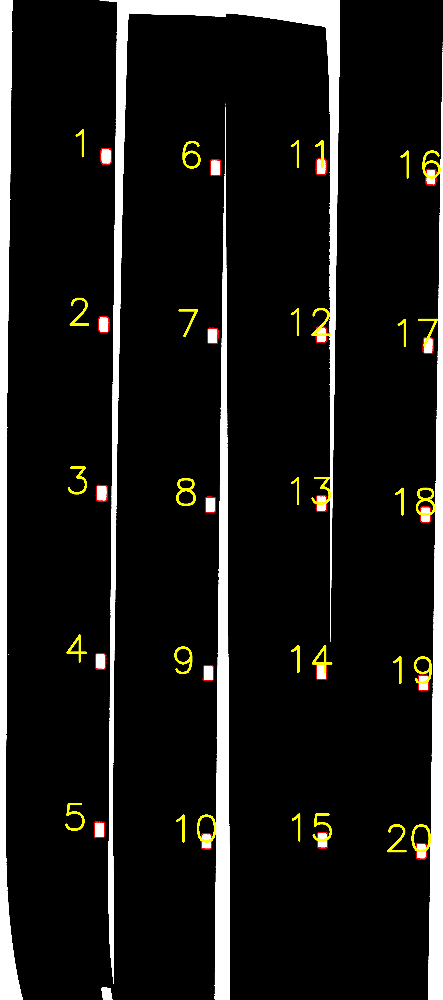

In [15]:
print("Perf count: %i" % len(perfs))

# order the perfs by X position
perfs.sort(key=lambda p: p[0][0])

# find strips
# ** (here we assume that the strips are *roughly* vertical)
perf_x_offset_thresh = 100

dxs = np.diff([p[0][0] for p in perfs])
strip_len = 1
n_strips = 1

i = 0
strip_start_idxs = [0]
for dx in dxs:
    if dx > perf_x_offset_thresh:
        strip_start_idxs.append(i+1)
    
    i+=1

perf_strips = []
i = 0
strip_idx = 0
for perf in perfs:
    if strip_idx < len(strip_start_idxs) and i == strip_start_idxs[strip_idx]:
        perf_strips.append([strip_start_idxs[strip_idx],[]])
        strip_idx+=1
    perf_strips[strip_idx-1][1].append(perf)
    i+=1

for strip in perf_strips:
    strip[1].sort(key=lambda p: p[0][1])

# draw the perf contours and number labels
img_cont = cv.cvtColor(img_dil, cv.COLOR_GRAY2RGB)

for strip in perf_strips:
    cv.drawContours(img_cont, list(zip(*strip[1]))[1], -1, (255,0,0), 8, cv.LINE_AA)
    for i, perf in enumerate(strip[1]):
        cv.putText(img_cont, str(i+strip[0]+1), [perf[0][0]-300, perf[0][1]], cv.FONT_HERSHEY_SIMPLEX, 10, (255,255,0), 20, cv.LINE_AA)

imdisp(img_cont)

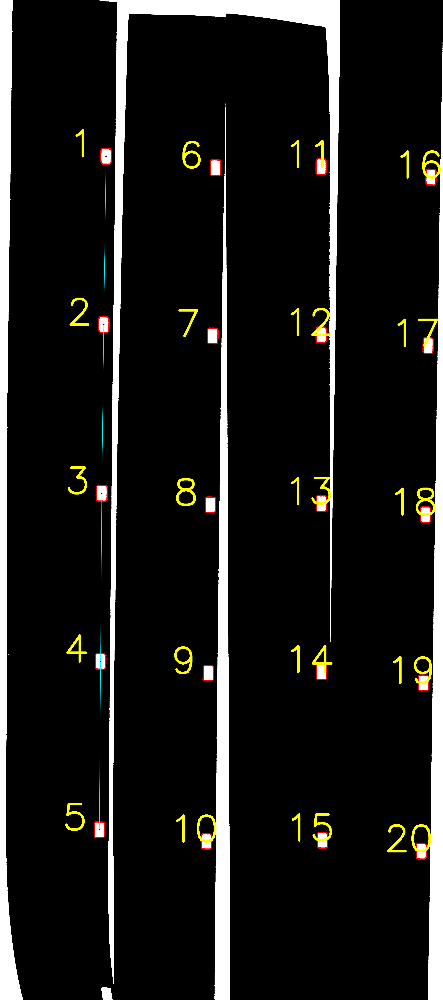

In [22]:
# connect the perf centroids with lines

strip = perf_strips[0][1]

img_perflines = img_cont.copy()
for i in range(1, len(strip)):
    perf0 = strip[i-1]
    perf1 = strip[i]
    
    cv.line(img_perflines, perf0[0], perf1[0], (0,255,255), 2, cv.LINE_AA)

for perf in strip:
    cv.line(img_perflines, perf[0], perf[0], (0,0,0), 10, cv.LINE_AA)

imdisp(img_perflines)

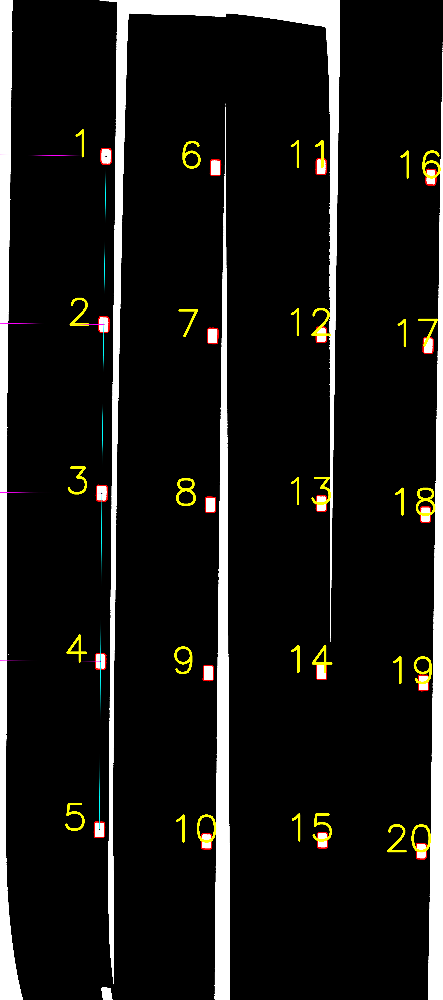

In [17]:
# calculate perpendicular lines

for i in range(1, len(strip)):
    perf0 = strip[i-1]
    perf1 = strip[i]
    
    line_vert = perf0[0] - perf1[0]
    frame_angle = np.arctan2(*line_vert)
    angle_perp = frame_angle + (np.pi / 2)

    line_len = 900
    line_horz = np.array([
      line_len * np.sin(angle_perp),
      line_len * np.cos(angle_perp)
    ]).astype(int)
    
    cv.line(img_perflines, perf0[0], perf0[0]+line_horz, (255,0,255), 2, cv.LINE_AA)
    
imdisp(img_perflines)

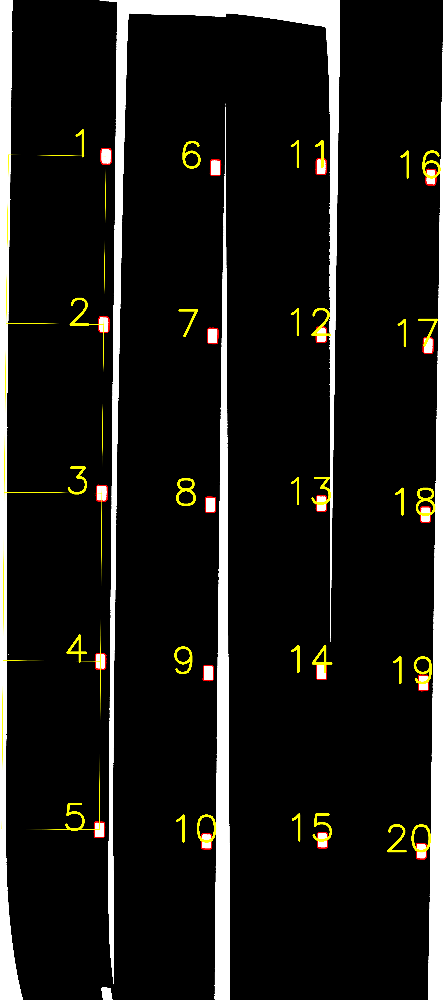

In [18]:
# calculate perpendicular lines

frames = []
for i in range(1, len(strip)):
    perf0 = strip[i-1]
    perf1 = strip[i]
    
    line_vert = perf0[0] - perf1[0]
    frame_angle = np.arctan2(*line_vert)
    angle_perp = frame_angle + (np.pi / 2)

    line_len = 800
    
    line_horz = np.array([
      line_len * np.sin(angle_perp),
      line_len * np.cos(angle_perp)
    ])
    
    frame_cont = np.array([
      [perf0[0]],
      [perf1[0]],
      [perf1[0] + line_horz],
      [perf0[0] + line_horz]
    ]).astype(np.int32)
    
    frames.append((perf0[0], frame_cont, frame_angle))

img_frameconts = img_cont.copy()
for frame in frames:
    cv.drawContours(img_frameconts, list(zip(*frames))[1], -1, (255,255,0), 2, cv.LINE_AA)
    
imdisp(img_frameconts)

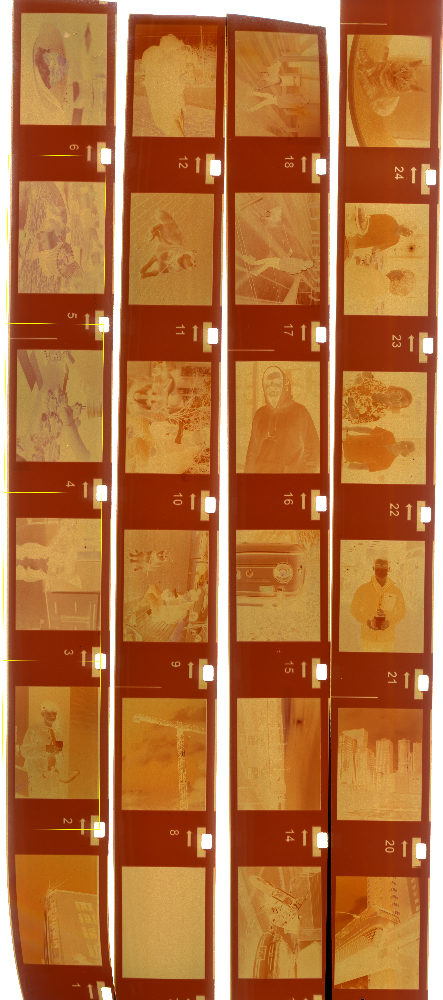

In [19]:
# let's see how those borders look on the original image

is_color = True

img_frameconts = img_color.copy()
if not is_color:
    img_frameconts = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
cv.drawContours(img_frameconts, list(zip(*frames))[1], -1, (255,255,0), 2, cv.LINE_AA)

for i, frame in enumerate(frames):
    cv.putText(img_frameconts, str(i), [frame[0][0]+10, frame[0][1]-5], cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv.LINE_AA)
    
imdisp(img_frameconts)

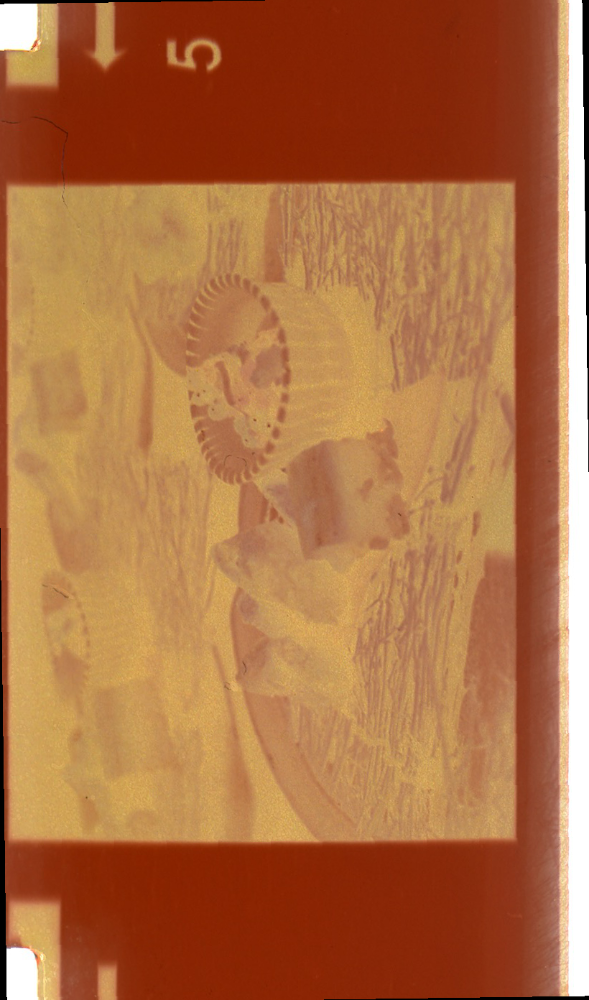

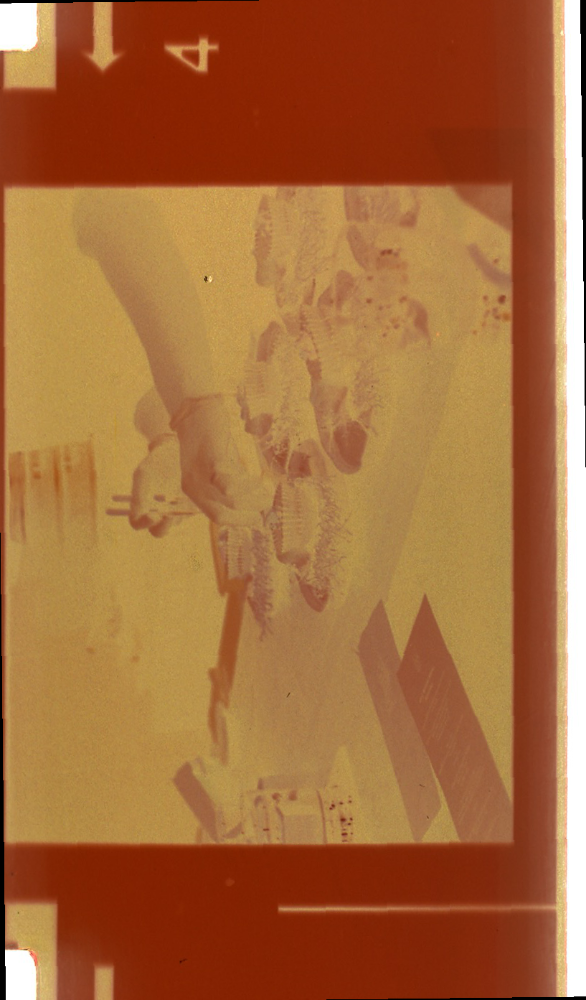

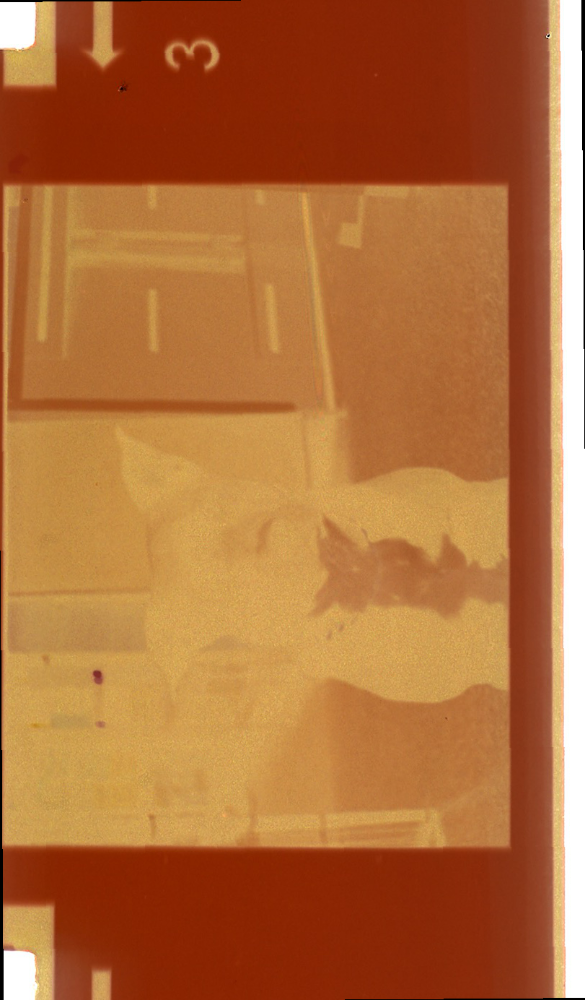

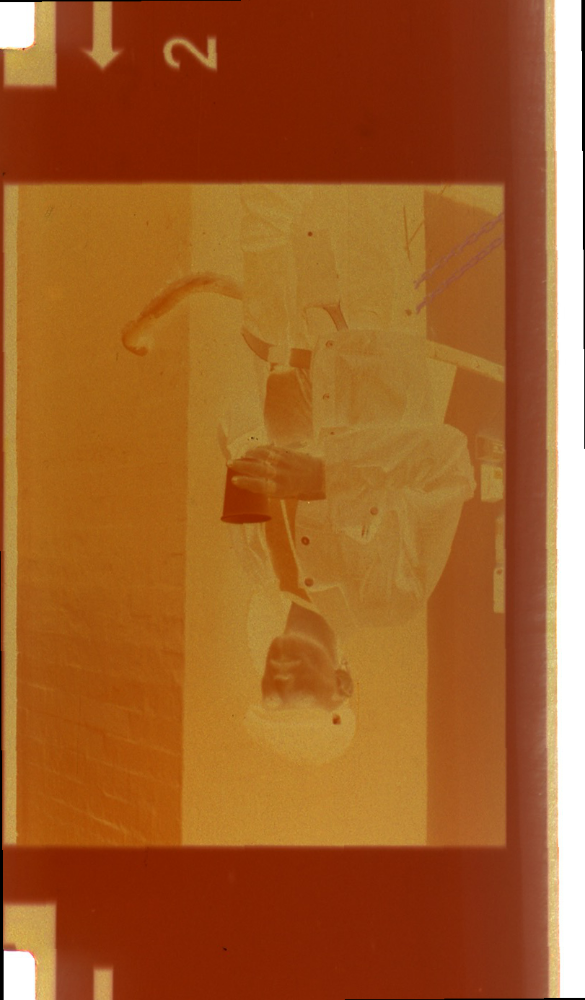

In [20]:
# crop out the frames and rotate them

for i, frame in enumerate(frames):
    x,y,w,h = cv.boundingRect(frame[1])
    frame_pxs = img_color[y:y+h, x:x+w]
    rframe = Image.fromarray(frame_pxs).rotate(np.rad2deg(-frame[2]))
    imdisp(np.array(rframe))